# V3.1

Vocab size 84

In [1]:
!unzip drive/MyDrive/audio/audioB

Streaming output truncated to the last 5000 lines.
  inflating: wav/9300.wav            
  inflating: wav/6033.wav            
  inflating: wav/1984.wav            
  inflating: wav/9314.wav            
  inflating: wav/6027.wav            
  inflating: wav/1748.wav            
  inflating: wav/1990.wav            
  inflating: wav/7339.wav            
  inflating: wav/4630.wav            
  inflating: wav/2241.wav            
  inflating: wav/5248.wav            
  inflating: wav/2527.wav            
  inflating: wav/3639.wav            
  inflating: wav/4156.wav            
  inflating: wav/6999.wav            
  inflating: wav/9472.wav            
  inflating: wav/6741.wav            
  inflating: wav/5260.wav            
  inflating: wav/3611.wav            
  inflating: wav/7477.wav            
  inflating: wav/8744.wav            
  inflating: wav/592.wav             
  inflating: wav/1006.wav            
  inflating: wav/6769.wav            
  inflating: wav/1760.wav            

In [2]:
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.functional import edit_distance
import torch
import torchaudio
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import math
import pickle

In [3]:
torch.manual_seed(0)

In [4]:
base_dir = ''
audio_dir = os.path.join(base_dir, 'wav')
labels_dir = os.path.join(base_dir, 'labels')
model_dir = os.path.join(base_dir, 'model')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# Helper class for processing notes
# Basically keeps track of useful structures and helps translate between string and one-hot tensors
class Vocab:
    def __init__(self):
        self.note2idx = {'{': 0, '}': 1, '<unk>': 2, '<pad>': 3}
        self.note2count = {'{': 0, '}': 0, '<unk>': 0, '<pad>': 0}
        self.idx2note = {0: '{', 1: '}', 2: '<unk>', 3: '<pad>'}
        self.n_notes = 4

    def add_notes(self, notes_str):
        for note in notes_str.split():
            self.add_note(note)

    def add_note(self, note):
        if note not in self.note2idx:
            self.note2idx[note] = self.n_notes
            self.note2count[note] = 1
            self.idx2note[self.n_notes] = note
            self.n_notes += 1
        else:
            self.note2count[note] += 1

    def notes_to_indices(self, notes: str):
        note_indices = []
        for note in notes.split(' '):
            if note in self.note2idx:
              note_indices.append(self.note2idx[note])
            else:
              note_indices.append(self.note2idx['<unk>'])
        return note_indices

    def indices_to_notes(self, indices):
        note_str = ''
        for i in indices:
            if i in self.idx2note:
                note_str += self.idx2note[i]
            else:
                note_str += '<unk>'
            note_str += ' '
        return note_str[:-1]

In [7]:
class BassDataset(Dataset):
    def __init__(self, audio_dir, labels_dir, vocab):
        self.labels_dir = labels_dir
        self.labels = list(filter(lambda x: x.endswith('.txt'), os.listdir(labels_dir)))
        self.audio_dir = audio_dir
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_dir, f'{idx}.wav')
        labels_file = os.path.join(self.labels_dir, f'{idx}.txt')
        # Load audio file, resample to 16kHz
        waveform, _ = librosa.load(audio_file, sr=16000)
        waveform = torch.tensor(waveform)

        # Load labels
        f =  open(labels_file, 'r')
        notes_str = f.read()
        notes = torch.tensor(self.vocab.notes_to_indices(notes_str))
        f.close()

        return waveform, notes

def collate_fn(batch):
    # Pad audio files and labels to the same length
    waveforms, labels = zip(*batch)
    padded_waveforms = torch.nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    # Pad index of label is 3
    padded_labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=3)
    return padded_waveforms, padded_labels

def build_dataloader(audio_dir, labels_dir, batch_size=1):
  # Load vocab
  vocab = Vocab()
  for label in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label), 'r') as f:
      vocab.add_notes(f.read())

  data = BassDataset(audio_dir, labels_dir, vocab)

  train_data, test_data = torch.utils.data.random_split(data, [int(0.9 * len(data)), len(data) - int(0.9 * len(data))])
  train_loader = DataLoader(train_data, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
  return vocab, train_loader, test_loader

In [15]:
# https://github.com/openai/whisper/blob/main/whisper/model.py
# Used for audio positional embedding
def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

class PositionalEncoding(nn.Module):
    # Adds PE to the target label
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 100):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        """
        Arguments:
            token_embedding: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class AudioEncoder(nn.Module):
    def __init__(self, n_state):
        super().__init__()
        self.n_state = n_state
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_state, kernel_size=256, stride=4, padding=1).to(device)
        self.pool1 = nn.MaxPool1d(kernel_size=64, stride=64, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n_state, out_channels=n_state, kernel_size=3, stride=1, padding=1).to(device)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.layer_norm = nn.LayerNorm(n_state).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(F.relu(x))
        x = self.conv2(x)
        x = self.pool2(F.relu(x))
        x = self.layer_norm(x.permute(0, 2, 1))
        positional_embedding = sinusoids(x.shape[1], self.n_state).to(x.dtype).to(device)
        x = x + positional_embedding
        return x

class Transcriber(nn.Module):
    def __init__(self,
             n_state: int,
             vocab,
             dropout: float = 0.2):
        super().__init__()
        self.vocab = vocab
        self.audio_encoder = AudioEncoder(n_state)
        self.transformer = nn.Transformer(d_model=n_state,
                                          num_encoder_layers=6,
                                          num_decoder_layers=6,
                                          dropout=dropout,
                                          batch_first=True)
        # converts one-hot labels of (T, vocab_size) to (T, n_filters)
        self.target_embedding = nn.Embedding(vocab.n_notes, n_state)
        # adds positional encoding to the embedded target
        self.positional_encoding = PositionalEncoding(n_state, dropout)
        self.generator = nn.Linear(n_state, vocab.n_notes)

    def forward(self, src, target):
        src = self.audio_encoder(src)    # (1, S, n_filters)
        tgt = self.target_embedding(target.to(device))  # (1, T - 1, n_filters)
        tgt = self.positional_encoding(tgt).to(device)  # (1, T - 1, n_filters)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        outs = self.transformer(src, tgt, tgt_mask=tgt_mask)
        outs = self.generator(outs)    # (1, seq, vocab_size)
        return outs

In [9]:
vocab, train_loader, test_loader = build_dataloader(audio_dir, labels_dir, batch_size=1)

In [10]:
vocab.n_notes

88

In [11]:
vocab.note2idx

{'{': 0,
 '}': 1,
 '<unk>': 2,
 '<pad>': 3,
 'd4': 4,
 'f,8': 5,
 'gis,2': 6,
 'e,2': 7,
 'gis8': 8,
 'cis8': 9,
 'cis2': 10,
 'g,1': 11,
 'ais2': 12,
 'f1': 13,
 'd2': 14,
 'a,2': 15,
 'e,8': 16,
 'f4': 17,
 'cis1': 18,
 'gis,8': 19,
 'gis,1': 20,
 'ais4': 21,
 'g,2': 22,
 'e2': 23,
 'e4': 24,
 'fis4': 25,
 'f,1': 26,
 'a2': 27,
 'gis2': 28,
 'fis2': 29,
 'r2': 30,
 'e,1': 31,
 'gis4': 32,
 'fis,4': 33,
 'ais,8': 34,
 'c1': 35,
 'dis8': 36,
 'fis8': 37,
 'a4': 38,
 'c8': 39,
 'dis4': 40,
 'g4': 41,
 'c4': 42,
 'e1': 43,
 'a,1': 44,
 'fis1': 45,
 'fis,1': 46,
 'b,1': 47,
 'b2': 48,
 'f2': 49,
 'g2': 50,
 'ais,2': 51,
 'dis2': 52,
 'd1': 53,
 'a,4': 54,
 'a,8': 55,
 'r8': 56,
 'dis1': 57,
 'a8': 58,
 'b8': 59,
 'gis1': 60,
 'ais1': 61,
 'gis,4': 62,
 'g1': 63,
 'f,2': 64,
 'b,4': 65,
 'r4': 66,
 'fis,2': 67,
 'fis,8': 68,
 'cis4': 69,
 'a1': 70,
 'g,4': 71,
 'b1': 72,
 'e,4': 73,
 'e8': 74,
 'b,8': 75,
 'c2': 76,
 'f,4': 77,
 'f8': 78,
 'ais,4': 79,
 'r1': 80,
 'g8': 81,
 'b,2': 82,
 'b

In [12]:
vocab.idx2note

{0: '{',
 1: '}',
 2: '<unk>',
 3: '<pad>',
 4: 'd4',
 5: 'f,8',
 6: 'gis,2',
 7: 'e,2',
 8: 'gis8',
 9: 'cis8',
 10: 'cis2',
 11: 'g,1',
 12: 'ais2',
 13: 'f1',
 14: 'd2',
 15: 'a,2',
 16: 'e,8',
 17: 'f4',
 18: 'cis1',
 19: 'gis,8',
 20: 'gis,1',
 21: 'ais4',
 22: 'g,2',
 23: 'e2',
 24: 'e4',
 25: 'fis4',
 26: 'f,1',
 27: 'a2',
 28: 'gis2',
 29: 'fis2',
 30: 'r2',
 31: 'e,1',
 32: 'gis4',
 33: 'fis,4',
 34: 'ais,8',
 35: 'c1',
 36: 'dis8',
 37: 'fis8',
 38: 'a4',
 39: 'c8',
 40: 'dis4',
 41: 'g4',
 42: 'c4',
 43: 'e1',
 44: 'a,1',
 45: 'fis1',
 46: 'fis,1',
 47: 'b,1',
 48: 'b2',
 49: 'f2',
 50: 'g2',
 51: 'ais,2',
 52: 'dis2',
 53: 'd1',
 54: 'a,4',
 55: 'a,8',
 56: 'r8',
 57: 'dis1',
 58: 'a8',
 59: 'b8',
 60: 'gis1',
 61: 'ais1',
 62: 'gis,4',
 63: 'g1',
 64: 'f,2',
 65: 'b,4',
 66: 'r4',
 67: 'fis,2',
 68: 'fis,8',
 69: 'cis4',
 70: 'a1',
 71: 'g,4',
 72: 'b1',
 73: 'e,4',
 74: 'e8',
 75: 'b,8',
 76: 'c2',
 77: 'f,4',
 78: 'f8',
 79: 'ais,4',
 80: 'r1',
 81: 'g8',
 82: 'b,2',
 83

In [13]:
vocab.note2count

{'{': 10000,
 '}': 10000,
 '<unk>': 0,
 '<pad>': 0,
 'd4': 1794,
 'f,8': 1731,
 'gis,2': 1739,
 'e,2': 1736,
 'gis8': 1678,
 'cis8': 1664,
 'cis2': 1769,
 'g,1': 1741,
 'ais2': 1746,
 'f1': 1654,
 'd2': 1693,
 'a,2': 1660,
 'e,8': 1647,
 'f4': 1702,
 'cis1': 1713,
 'gis,8': 1720,
 'gis,1': 1711,
 'ais4': 1668,
 'g,2': 1699,
 'e2': 1773,
 'e4': 1706,
 'fis4': 1732,
 'f,1': 1726,
 'a2': 1751,
 'gis2': 1686,
 'fis2': 1746,
 'r2': 1387,
 'e,1': 1710,
 'gis4': 1772,
 'fis,4': 1673,
 'ais,8': 1695,
 'c1': 1717,
 'dis8': 1716,
 'fis8': 1768,
 'a4': 1689,
 'c8': 1745,
 'dis4': 1705,
 'g4': 1770,
 'c4': 1661,
 'e1': 1699,
 'a,1': 1772,
 'fis1': 1669,
 'fis,1': 1757,
 'b,1': 1784,
 'b2': 1716,
 'f2': 1717,
 'g2': 1726,
 'ais,2': 1763,
 'dis2': 1772,
 'd1': 1770,
 'a,4': 1727,
 'a,8': 1735,
 'r8': 1397,
 'dis1': 1704,
 'a8': 1809,
 'b8': 1732,
 'gis1': 1709,
 'ais1': 1733,
 'gis,4': 1761,
 'g1': 1765,
 'f,2': 1787,
 'b,4': 1690,
 'r4': 1400,
 'fis,2': 1794,
 'fis,8': 1756,
 'cis4': 1660,
 'a1': 1

## Training

In [16]:
transcriber_v3_1 = Transcriber(n_state=256, vocab=vocab).to(device)

In [22]:
def train(model, epoch, log_interval=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-6)
    criterion = nn.CrossEntropyLoss()
    model.train()
    losses = []
    for batch_id, (audio, label) in enumerate(train_loader):


        audio = audio.unsqueeze(1).to(device)
        label = label.to(device)
        optimizer.zero_grad()

        tgt_in = label[:, :-1]

        out = model(audio, tgt_in)

        tgt_out = label[:, 1:]

        loss = criterion(out.squeeze(0), tgt_out.squeeze(0))
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        if batch_id % log_interval == 0:
            print('-' * 50)
            print(f'Epoch {epoch} Batch {batch_id} Loss: {loss.item()}')
    return losses

def inference(model, audio: torch.Tensor) -> str:
    with torch.no_grad():
        model.eval()
        max_len = 20
        src = model.audio_encoder(audio.unsqueeze(0).to(device))  # (1, S, n_filters)
        memory = model.transformer.encoder(src)
        tgt = torch.zeros((1, max_len), dtype=torch.int32).to(device)
        tgt[0, 1:] = 2  # set first to SOS and the rest to <unk>
        tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        for i in range(max_len - 1):
            tgt_in = model.target_embedding(tgt)  # (1, max_len, n_filters)
            tgt_in = model.positional_encoding(tgt_in)  # (1, max_len, n_filters)
            out = model.transformer.decoder(tgt_in, memory, tgt_mask=tgt_mask)  # (1, max_len, n_filters)
            out = model.generator(out)  # (1, max_len, vocab)
            out = F.softmax(out.squeeze(0)[:i + 1], dim=1).argmax(dim=1)[-1]  # int
            tgt[0, i + 1] = out
            if out == 1:
                # Found end token, stop
                break

        print(tgt[0])
        predicted = model.vocab.indices_to_notes(tgt[0].tolist()).split('<unk>')[0].strip()
        return predicted

In [23]:
train_losses = []
for epoch in range(20):
  train_losses += train(transcriber_v3_1, epoch + 1, log_interval=1000)

--------------------------------------------------
Epoch 1 Batch 0 Loss: 4.369722366333008
--------------------------------------------------
Epoch 1 Batch 1000 Loss: 4.481348514556885
--------------------------------------------------
Epoch 1 Batch 2000 Loss: 4.4311017990112305
--------------------------------------------------
Epoch 1 Batch 3000 Loss: 4.347699165344238
--------------------------------------------------
Epoch 1 Batch 4000 Loss: 4.323678016662598
--------------------------------------------------
Epoch 1 Batch 5000 Loss: 4.255419731140137
--------------------------------------------------
Epoch 1 Batch 6000 Loss: 4.425727844238281
--------------------------------------------------
Epoch 1 Batch 7000 Loss: 4.170024394989014
--------------------------------------------------
Epoch 1 Batch 8000 Loss: 4.042449474334717
--------------------------------------------------
Epoch 2 Batch 0 Loss: 4.314324855804443
--------------------------------------------------
Epoch 2 Batch 

In [36]:
sample_wav = torch.tensor(librosa.load('wav/0.wav', sr=16000)[0]).unsqueeze(0).to(device)

In [37]:
# Check logit outputs after training
inference(transcriber_v3_1, sample_wav)

tensor([ 0, 70, 58, 58, 48, 56, 10, 26, 54, 47, 32, 27,  5, 33, 30, 64,  1,  2,
         2,  2], device='cuda:0', dtype=torch.int32)


'{ a1 a8 a8 b2 r8 cis2 f,1 a,4 b,1 gis4 a2 f,8 fis,4 r2 f,2 }'

In [27]:
# State dict after training
transcriber_v3_1.state_dict()

OrderedDict([('audio_encoder.conv1.weight',
              tensor([[[ 0.0604,  0.0493, -0.0175,  ...,  0.0266,  0.0121, -0.0182]],
              
                      [[-0.0378, -0.0310, -0.0008,  ..., -0.0063,  0.0474,  0.0544]],
              
                      [[-0.0415, -0.0191, -0.0516,  ...,  0.0095,  0.0235, -0.0148]],
              
                      ...,
              
                      [[ 0.0337, -0.0123, -0.0020,  ..., -0.0267,  0.0003,  0.0291]],
              
                      [[-0.0412,  0.0378,  0.0563,  ..., -0.0154, -0.0448,  0.0482]],
              
                      [[ 0.0330,  0.0535,  0.0508,  ...,  0.0511,  0.0503, -0.0226]]],
                     device='cuda:0')),
             ('audio_encoder.conv1.bias',
              tensor([ 0.0090,  0.0325,  0.0477, -0.0107, -0.0730,  0.0459, -0.0288,  0.0305,
                       0.0214,  0.0059,  0.0558, -0.0556, -0.0604, -0.0270, -0.0244, -0.0201,
                       0.0426, -0.0016,  0.0097, -0.

In [48]:
# Save model
model_sd_path_trained = 'drive/MyDrive/audio/autobass-3.1.pth'
model_path_trained = 'drive/MyDrive/audio/autobass-3.1.pt'
torch.save(transcriber_v3_1.state_dict(), model_sd_path_trained)
torch.save(transcriber_v3_1, model_path_trained)

In [39]:
# Load trained model in same session
loaded_model = torch.load(model_path_trained, map_location=device)
inference(loaded_model, sample_wav)

tensor([ 0, 70, 58, 58, 48, 56, 10, 26, 54, 47, 32, 27,  5, 33, 30, 64,  1,  2,
         2,  2], device='cuda:0', dtype=torch.int32)


'{ a1 a8 a8 b2 r8 cis2 f,1 a,4 b,1 gis4 a2 f,8 fis,4 r2 f,2 }'

In [ ]:
# Load trained model in different session
model_path_trained = 'drive/MyDrive/audio/autobass-debug-trained.pt'
loaded_model = torch.load(model_path_trained, map_location=device)
sample_wav = torch.tensor(librosa.load('audio3/wav/0.wav', sr=16000)[0]).unsqueeze(0).to(device)
inference(loaded_model, sample_wav)

tensor([[ 0, 32, 22, 22, 19, 69, 38,  5, 75, 15, 42, 36, 56, 43, 48, 33]])
tensor([[[-0.9457, -2.4694, -0.8855,  ...,  0.7069,  0.4551,  1.2515],
         [-1.4323, -2.3053, -1.3975,  ...,  0.6309,  0.4562,  1.2132],
         [-1.5489, -2.0452, -1.5473,  ...,  0.6089,  0.4190,  1.2732],
         ...,
         [-3.7671, -0.0051, -3.7772,  ...,  0.3777,  0.2923,  1.2545],
         [-3.8931,  0.2157, -3.8786,  ...,  0.3500,  0.2707,  1.2166],
         [-3.9488,  1.6516, -4.0079,  ...,  0.4113,  0.2840,  0.8003]]],
       grad_fn=<ViewBackward0>)
a1 a1 a1 a1 a1 a1 a1 a1 a1 f,1 f,1 f,1 f,1 f,1 f,1 f,1


In [ ]:
loaded_model.state_dict()

OrderedDict([('audio_encoder.conv1.weight',
              tensor([[[ 0.0612,  0.0505, -0.0160,  ...,  0.0303,  0.0156, -0.0149]],
              
                      [[-0.0397, -0.0332, -0.0033,  ..., -0.0135,  0.0394,  0.0455]],
              
                      [[-0.0384, -0.0163, -0.0490,  ...,  0.0122,  0.0271, -0.0102]],
              
                      ...,
              
                      [[ 0.0340, -0.0123, -0.0022,  ..., -0.0256,  0.0016,  0.0305]],
              
                      [[-0.0391,  0.0400,  0.0588,  ..., -0.0152, -0.0442,  0.0491]],
              
                      [[ 0.0337,  0.0534,  0.0500,  ...,  0.0506,  0.0503, -0.0222]]])),
             ('audio_encoder.conv1.bias',
              tensor([ 1.3646e-02,  3.9111e-02,  5.2356e-02, -7.0825e-03, -6.3286e-02,
                       4.9169e-02, -2.5809e-02,  3.3790e-02,  2.4312e-02,  1.0150e-02,
                       5.3605e-02, -5.2287e-02, -5.3916e-02, -2.2954e-02, -1.8352e-02,
                 

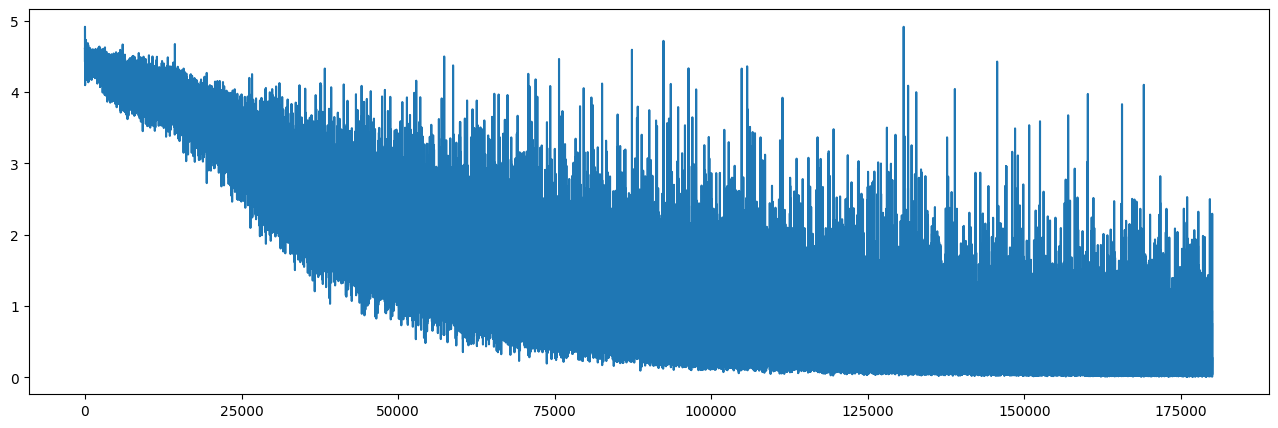

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(train_losses)

In [43]:
wav, lbl = next(iter(train_loader))
out = transcriber_v3_1(wav.unsqueeze(0).to(device), lbl[:, :-1].to(device))

In [44]:
vocab.indices_to_notes(F.softmax(out.squeeze(0), dim=1).argmax(dim=1).tolist())

'gis8 g1 dis4 fis,1 gis4 g,2 r2 fis,1 f2 gis1 e,2 fis,4 }'

In [45]:
vocab.indices_to_notes(lbl[0, 1:].tolist())

'gis8 g1 dis4 fis,1 gis4 g,2 r2 fis,1 f2 gis1 e,2 fis,4 }'

# Evaluation

In [ ]:
loaded_model = torch.load(model_path, map_location=device)

In [46]:
def test(model, log_interval=100):
  with torch.no_grad():
      model.eval()
      max_len = 20
      ceds = []  # character edit distances
      weds = []  # word edit distances
      cers = []  # character error rates
      wers = []  # word error rates

      for batch_id, (audio, label) in enumerate(test_loader):
          src = model.audio_encoder(audio.unsqueeze(0).to(device))   # (1, S, n_filters)
          memory = model.transformer.encoder(src)

          tgt = torch.zeros((1, max_len), dtype=torch.int32).to(device)
          tgt[0, 1:] = 2  # set first to SOS and the rest to <unk>
          tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
          for i in range(max_len-1):
            tgt_in = model.target_embedding(tgt)  # (1, max_len, n_filters)
            tgt_in = model.positional_encoding(tgt_in)  # (1, max_len, n_filters)
            out = model.transformer.decoder(tgt_in, memory, tgt_mask=tgt_mask)  # (1, max_len, n_filters)
            out = model.generator(out)  # (1, max_len, vocab)
            out = F.softmax(out.squeeze(0)[:i+1], dim=1).argmax(dim=1)[-1]  # int
            tgt[0, i+1] = out
            if out == 1:
              # Found end token, stop
              break

          label = model.vocab.indices_to_notes(label[0].tolist())
          label_words = label.split(' ')
          predicted = model.vocab.indices_to_notes(tgt[0].tolist()).split('<unk>')[0].strip()
          predicted_words = predicted.split(' ')
          ced = edit_distance(label, predicted)
          wed = edit_distance(label_words, predicted_words)
          cer = ced / len(label)
          wer = wed / len(label_words)

          ceds.append(ced)
          weds.append(wed)
          cers.append(cer)
          wers.append(wer)

          if batch_id % log_interval == 0:
            print('-' * 20)
            print(f'Batch {batch_id}')
            print(f'Label:\t\t{label}')
            print(f'Predicted:\t{predicted}')
            print(f'Char distance:\t{ced}')
            print(f'Word distance:\t{wed}')
            print(f'Char error:\t{cer}')
            print(f'Word error:\t{wer}')

      print('-' * 20)
      print(f'Total test samples: {len(ceds)}')
      print(f'Avg char distance:\t{"{:.2f}".format(sum(ceds) / len(ceds))} characters')
      print(f'Avg word distance:\t{"{:.2f}".format(sum(weds) / len(weds))} words')
      print(f'Avg char error:\t{"{:.2f}".format(100 * sum(cers) / len(cers))}%')
      print(f'Avg word error:\t{"{:.2f}".format(100 * sum(wers) / len(wers))}%')
      return ceds, weds, cers, wers

In [47]:
_ = test(loaded_model, log_interval=100)

--------------------
Batch 0
Label:		{ b8 g1 fis,2 f,4 dis8 fis,1 gis2 dis8 g8 d2 a1 gis,8 f,2 ais2 fis,1 ais4 }
Predicted:	{ b8 g1 fis,2 f,4 dis8 fis,1 gis2 dis8 g8 g8 d2 a1 gis,8 f,2 ais2 fis,1 ais4 }
Char distance:	3
Word distance:	1
Char error:	0.04
Word error:	0.05555555555555555
--------------------
Batch 100
Label:		{ g1 b,2 r1 fis2 gis2 b,1 d2 gis8 b8 d2 g8 g4 fis8 f2 }
Predicted:	{ g1 b,2 r1 fis2 gis2 b,1 d2 gis8 b8 d2 g8 g4 fis8 f2 fis8 }
Char distance:	5
Word distance:	1
Char error:	0.09090909090909091
Word error:	0.0625
--------------------
Batch 200
Label:		{ g,2 dis1 e8 fis,4 a4 dis8 b,4 e,2 gis1 dis8 c4 a1 c2 ais2 }
Predicted:	{ g,2 dis1 e8 fis,4 a4 dis8 b,4 e,2 gis1 dis8 c4 a1 c2 ais2 }
Char distance:	0
Word distance:	0
Char error:	0.0
Word error:	0.0
--------------------
Batch 300
Label:		{ f4 fis,2 g4 gis1 cis1 r8 g,8 dis1 b,1 dis8 f2 e8 ais,2 ais,4 e2 b,8 fis,8 c1 fis,1 }
Predicted:	{ f4 fis,2 g4 gis1 cis1 r8 g,8 dis1 b,1 dis8 f2 e8 ais,2 ais,4 e2 b,8 fis,8 b,8 fis,8